In [1]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from os import path
import cv2
import scipy.misc

In [2]:
dados = np.loadtxt('ocr_car_numbers_rotulado.txt')


In [3]:
def getImage(data, row):
    image = data[row, :-1] #seleciona a lilha e apaga o útima coluna
    image.shape = (35, 35) #converte para duas dimensões
    image[image==1]=255
    image = np.uint8(image)
    return image

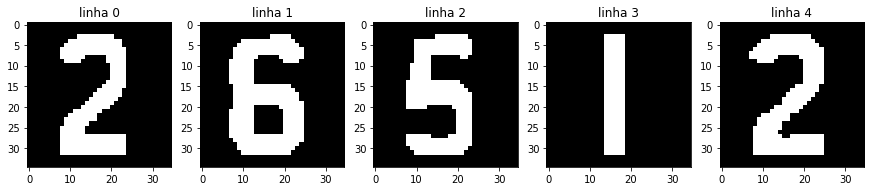

In [24]:
linhas = 5

imgs = [getImage(dados, i) for i in range(len(dados))]

plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')


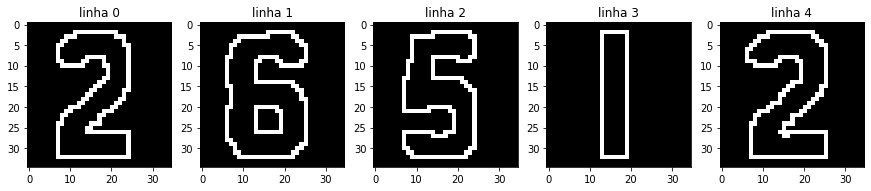

In [28]:
#canny = cv2.Canny(img,100,300)
#edges = canny.copy()

kernel = np.ones((3,3), np.uint8)
edges = [cv2.dilate(img, kernel, iterations=1) - img for img in imgs] #array de bordas do array de imagens
 
plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(edges[i], 'gray')


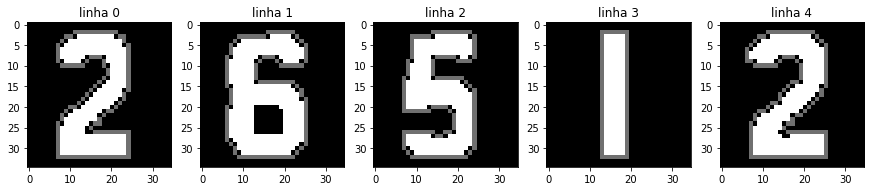

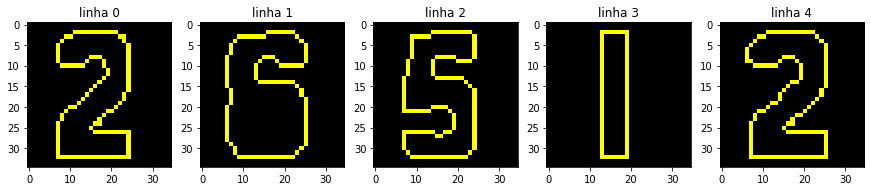

In [77]:
newImgs = []
n_contours = []

for i in range(len(edges)):
    contours, hierarchy = cv2.findContours(edges[i],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    n_contours.append(contours)

    maior = 0 #descobrir qual conjunto de contornos tem mais pontos
    for sizet in range(len(contours)):
        if (len(contours[sizet])>maior):
            maior = sizet

    newImg = np.zeros([35,35,3])
    newImg = np.uint8(newImg)

    for ind_contour in range(len(contours)):

        imgs[i] = cv2.polylines(imgs[i][:],contours,True,(112,255,255),1)#desenhando o poligono de acordo com os pontos
        newImg = cv2.polylines(newImg,contours,True,(0,255,255),1)#desenhando o poligono de acordo com os pontos
        
    newImgs.append(newImg)
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    newImgs[i] = cv2.cvtColor(newImgs[i], cv2.COLOR_BGR2RGB)
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(newImgs[i], 'gray')

In [78]:
def getChainCode(x1, y1, x2, y2): 
    dx = x2 - x1 
    dy = y2 - y1 
    
    if dx>0: #Significa que as posições podem ser (5,4,3)
        if dy <0 :
            code = 5
        elif dy==0:
            code = 4
        else:
            code = 3

    elif dx==0: # Significa que as posicoes podem ser (6,2)
        if dy<0:
            code = 6
        elif dy>0:
            code = 2
        else:
            code=8
    else: #Significa que as posicoes podem ser (7,0,1)
        if dy<0:
            code = 7
        elif dy==0:
            code = 0
        else:
            code = 1

    return code 

In [79]:
def generateChainCode(ListOfPoints): 
    chainCode = [] 
    textChain = " "
    for i in range(len(ListOfPoints)):
        a = ListOfPoints[i][0]
        #print("valor de A = ",a[0],a[1]) 
        if i != len(ListOfPoints)-1:
            b = ListOfPoints[i + 1][0]
            #print("valor de B = ",b[0],b[1])
        else :
            b = ListOfPoints[0][0] 
        chainCode.append(getChainCode(a[0], a[1], b[0], b[1]))
        textChain = textChain + str(getChainCode(a[0], a[1], b[0], b[1]))
        textChainT = str(getChainCode(a[0], a[1], b[0], b[1]))
        #DESCOMENTAR A LINHA ABAIXO PARA MOSTRAR O CODIGO DE CADA PONTO
        #cv2.putText(edges,textChainT, (a[0],a[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)
    return chainCode,textChain 

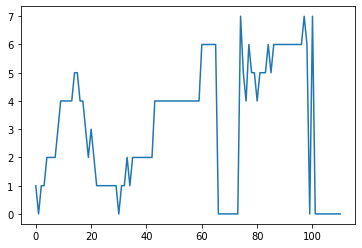

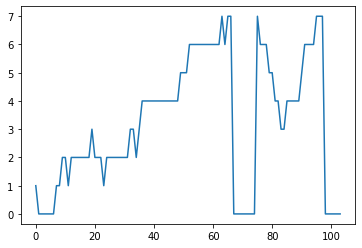

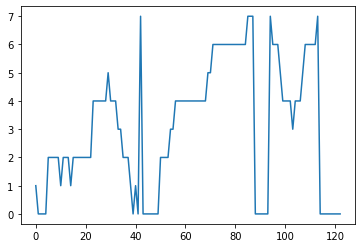

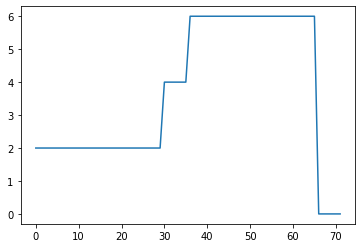

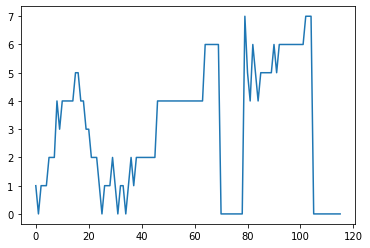

In [80]:
chainCodes = []

for contours in n_contours:
    chainCode,tsx = generateChainCode(contours[0])
    chainCodes.append(chainCode)
    #print("chain code ",ind_contour," = ", tsx)
    #print("sum ",ind_contour," = ",sum(chainCode))
    #print("Quantidade de pontos =",len(contours[ind_contour]))
    
for i in range(linhas):
    plt.plot(chainCodes[i])
    plt.show()
